## Stochastic SIR model using odin

Author: Thibaut Jombart @thibautjombart

Date: 2018-10-03

### Requirements

This code uses [*odin*](https://github.com/mrc-ide/odin), an **R** package for describing an solving differential equations. The commented commands will install the latest version of the package and its dependencies:

In [1]:
#if (!require("drat")) install.packages("drat")
#drat:::add("mrc-ide")
#install.packages("dde")
#install.packages("odin")
library(odin)

### Basic model

[`odin`](https://github.com/mrc-ide/odin) models can be specified in a separate source file, or directly in an R script, as below. Note that while `odin` code resembles **R**, it is **not R code** code per se - not everything that works in **R** may work in `odin` code. 

The discrete, stochastic SIR model can be formulated in `odin` as follows:

In [2]:
sir_generator <- odin::odin({
  ## Core equations for transitions between compartments:
  update(S) <- S - n_SI
  update(I) <- I + n_SI - n_IR
  update(R) <- R + n_IR

  ## Individual probabilities of transition:
  p_SI <- 1 - exp(-beta * I / N) # S to I
  p_IR <- 1 - exp(-gamma) # I to R

  ## Draws from binomial distributions for numbers changing between
  ## compartments:
  n_SI <- rbinom(S, p_SI)
  n_IR <- rbinom(I, p_IR)

  ## Total population size
  N <- S + I + R

  ## Initial states:
  initial(S) <- S_ini
  initial(I) <- I_ini
  initial(R) <- 0

  ## User defined parameters - default in parentheses:
  S_ini <- user(1000)
  I_ini <- user(1)
  beta <- user(0.2)
  gamma <- user(0.1)
    
}, verbose = FALSE)

The model is first parsed and compiled using `odin::odin`, and user-provided parameters are passed using the resulting model generator (the object `sir_generator`): 

In [3]:
sir <- sir_generator(I_ini = 10)
sir

<odin_model>
  Public:
    clone: function (deep = FALSE) 
    contents: function () 
    graph_data: function () 
    init: 1000 10 0
    initial: function (step) 
    initialize: function (user = NULL) 
    name: odin
    names: step S I R
    ptr: externalptr
    run: function (step, y = NULL, ..., use_names = TRUE, replicate = NULL) 
    set_user: function (..., user = list(...)) 
    transform_variables: function (y) 
    update: function (step, y) 
    update_cache: function () 
    user_info: function () 
    variable_order: list

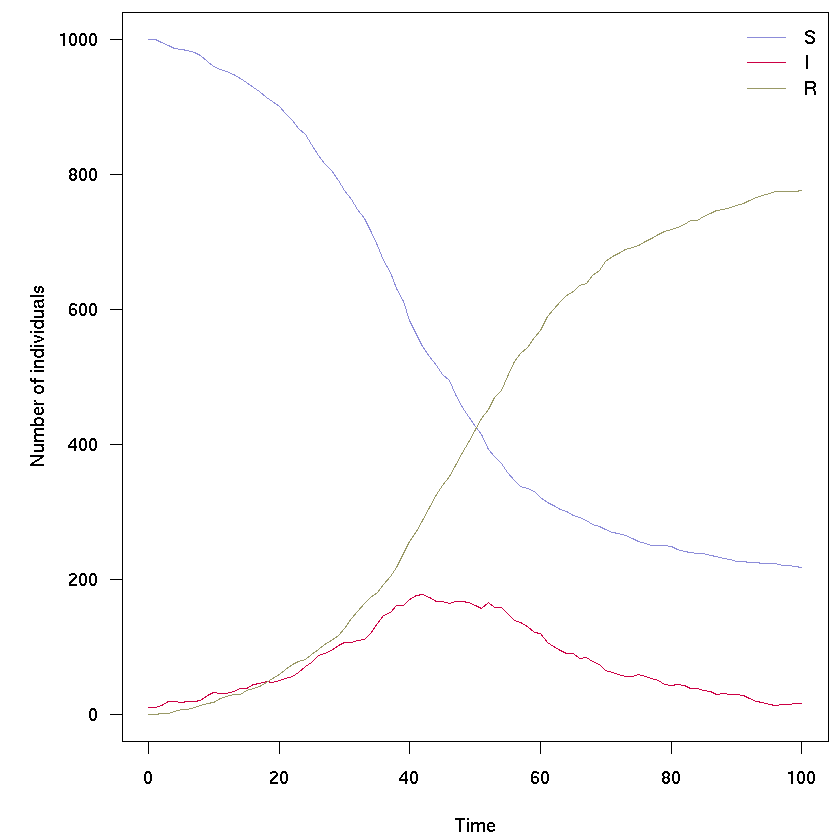

In [4]:
set.seed(1)
sir_col <- c("#8c8cd9", "#cc0044", "#999966")

res <- sir$run(0:100)
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
matplot(res[, 1], res[, -1], xlab = "Time", ylab = "Number of individuals",
        type = "l", col = sir_col, lty = 1)
legend("topright", lwd = 1, col = sir_col, legend = c("S", "I", "R"), bty = "n")

### Running multiple simulations

In the following we illustrate how the `odin` model `sir` can be used to generate *replicates*, i.e. several independent runs of the model; it takes a bit of reformatting the output - see next section for some helpful wrappers:

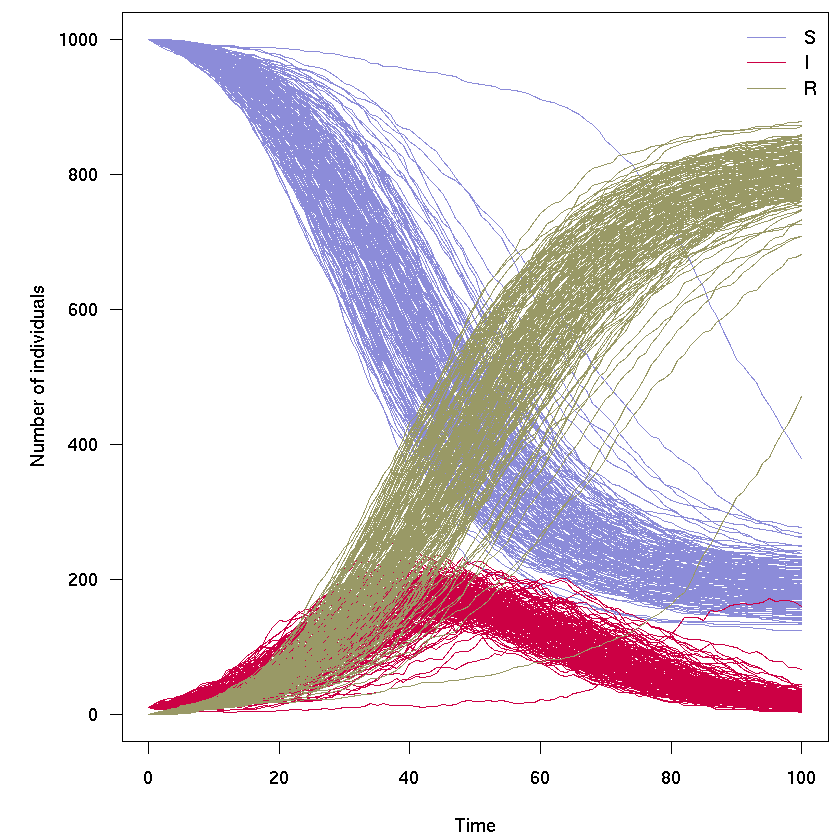

In [5]:
res_200 <- sir$run(0:100, replicate = 200)
res_200 <- sir$transform_variables(res_200)
res_200 <- cbind.data.frame(t = res_200[[1]], res_200[-1])

col <- rep(sir_col, each = 200)
                 
par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
matplot(res_200[, 1], res_200[, -1], xlab = "Time", ylab = "Number of individuals",
        type = "l", col = col, lty = 1)
legend("topright", lwd = 1, col = sir_col, legend = c("S", "I", "R"), bty = "n")

## Simplified workflow
Here we provide some helper functions for formatting *odin* output with multiple replicates, and plotting the results
### Helper functions

In [6]:
## x: instance of odin model
## t: time steps
## n: number of replicates
run_model <- function(x, t = 0:100, n = 1, ...) {
    res <- x$run(t, replicate = n, ...)
    res <- x$transform_variables(res)
    res <- cbind.data.frame(t = res[[1]], res[-1])
    attr(res, "n_compartments") <- length(x$names) - 1
    attr(res, "n_replicates") <- n
    attr(res, "compartments") <- x$names[-1]
    class(res) <- c("pretty_odin", class(res))
    res
}

sir_pal <- colorRampPalette(sir_col)

plot.pretty_odin <- function(x, pal = sir_pal, ...) {
    ## handle colors
    n_compartments <- attr(x, "n_compartments")
    n_replicates <- attr(x, "n_replicates")
    col_leg <- pal(n_compartments)
    alpha <- max(10 / n_replicates, 0.05)
    col <- rep(col_leg, each = n_replicates)

    ## make plot
    par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
    matplot(x[, 1], x[, -1], xlab = "Time", ylab = "Number of individuals",
            type = "l", col = col, lty = 1, ...)
    legend("topright", lwd = 1, col = col_leg, bty = "n",
           legend = attr(x, "compartments"))
}


### Example of simulations
With 120 time steps, 500 independent replicates:

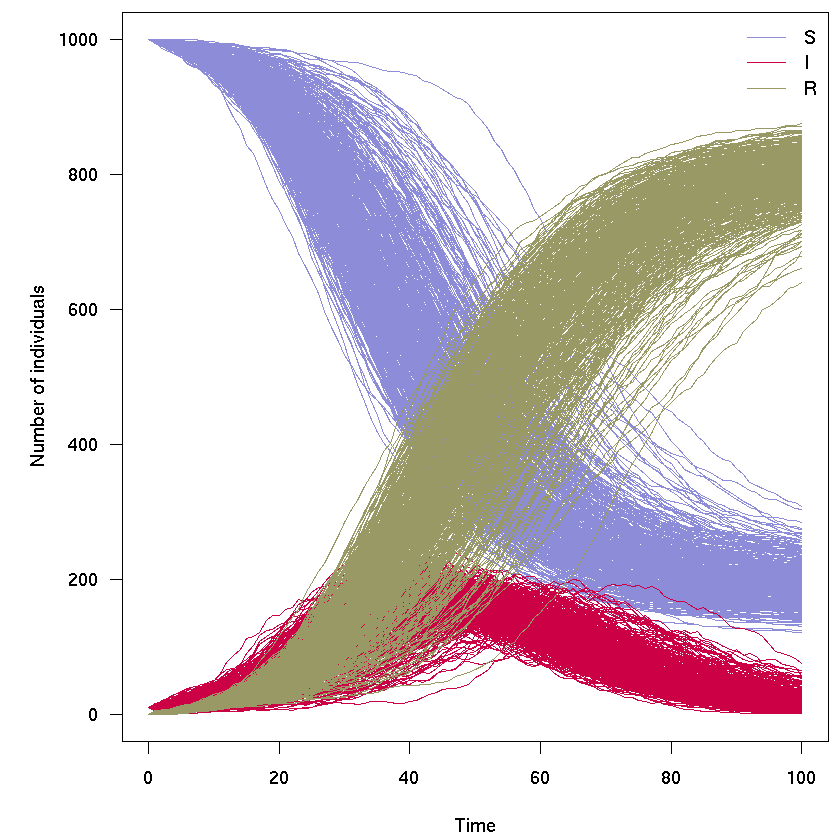

In [7]:
x <- run_model(sir, t = 0:100, n = 500)
plot(x)